In [36]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [37]:
words = open("names.txt", "r").read().splitlines()
chars = sorted(list(set("".join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi["."] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(stoi)

In [38]:
import random
random.seed(42)
random.shuffle(words)

In [39]:
block_size=3

def build_dataset(words):
    block_size = 3 # context length: how many characters do we take to predict the next one? 
    X, Y = [], [] # input, labels
    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] #crop and append new character

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [40]:
for x, y, in zip(Xtr[:20], Ytr[:20]):
    print("".join([itos[ix.item()] for ix in x])," --> ",  itos[y.item()])

...  -->  e
..e  -->  b
.eb  -->  r
ebr  -->  i
bri  -->  m
rim  -->  a
ima  -->  .
...  -->  h
..h  -->  i
.hi  -->  l
hil  -->  t
ilt  -->  o
lto  -->  n
ton  -->  .
...  -->  j
..j  -->  h
.jh  -->  e
jhe  -->  n
hen  -->  e
ene  -->  .


In [41]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

In [42]:
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        #buffers (trained with a running momentum update)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculate forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # mean over batch
            xvar = x.var(0, keepdim=True) # variance over batch
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize
        self.out = self.gamma * xhat + self.beta # scale and shift
        #update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

In [43]:
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

In [44]:
torch.manual_seed(42)

In [45]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

C = torch.randn((vocab_size, n_embd))
layers = [
    Linear(n_embd*block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
]

with torch.no_grad():
    # last layer: make less confident
    layers[-1].weight *= 0.1

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

12097


In [50]:
max_steps = 200000
batch_size=32
lossi=[]
ud = []

for i in range(max_steps):

    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # Forward pass
    emb = C[Xb] # embedd characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss function

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = 0.1 if i < 100000 else 0.01 # learning rate decay
    for p in parameters:
        p.data += -lr*p.grad

    #track stats
    if i % 10000 == 0:
            print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

    # if i >= 1000:
    #     break # AFTER_DEBUG: would take out obviously to run full optimalization

      0/ 200000: 2.1603
  10000/ 200000: 1.7816
  20000/ 200000: 2.1330
  30000/ 200000: 2.4700
  40000/ 200000: 2.0966
  50000/ 200000: 1.9109
  60000/ 200000: 2.3791
  70000/ 200000: 1.9880
  80000/ 200000: 2.0692
  90000/ 200000: 2.3297
 100000/ 200000: 2.2270
 110000/ 200000: 2.2950
 120000/ 200000: 2.5060
 130000/ 200000: 1.9408
 140000/ 200000: 1.9618
 150000/ 200000: 2.4154
 160000/ 200000: 1.9031
 170000/ 200000: 2.1075
 180000/ 200000: 1.8479
 190000/ 200000: 2.0800


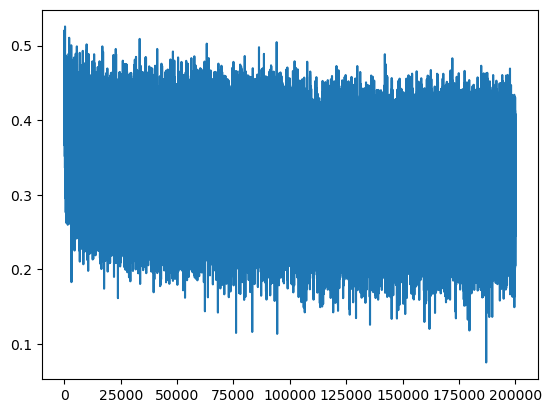

In [47]:
plt.plot(lossi)

In [48]:
@torch.no_grad() # disabled gradient tracking
def split_loss(split):
    x, y = {
        "train": (Xtr, Ytr),
        "val": (Xdev, Ydev),
        "test": (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_emb)
    x = emb.view(emb.shape[0], -1) # (N, block_size * n_emb)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y)
    print(split, loss.item())

split_loss("train")
split_loss("val")

train 2.06152081489563
val 2.108250141143799


In [49]:
# sample from the model

for _ in range(20):
    out = []
    while True:
        emb = C[torch.tensor([context])]
        x = emb.view(emb.shape[0], -1)
        for layer in layers:
            x = layer(x)
        logits = x
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print("".join(itos[i] for i in out))


RuntimeError: probability tensor contains either `inf`, `nan` or element < 0